In [4]:
# arima model (Autoregression Integrated Moving Average )


# import the necessary libraries 

!pip install matplotlib
!pip install pandas
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time 


In [5]:
df = pd.read_csv("dataset/STOCK_US_XNAS_MSFT.csv")

In [6]:
df.head(5)

,Date,Open,High,Low,Close,Volume
0,03/05/2025,389.34,401.67,388.81,401.02,"23,433,131"
1,03/04/2025,383.40,392.58,381.00,388.61,"29,342,920"
2,03/03/2025,398.82,398.82,386.16,388.49,"23,007,730"
3,02/28/2025,392.66,397.63,386.57,396.99,"32,845,660"
4,02/27/2025,401.27,405.74,392.17,392.53,"21,127,410"


In [7]:
df.tail(5)

,Date,Open,High,Low,Close,Volume
246,03/11/2024,403.76,405.68,401.26,404.52,"16,120,750"
247,03/08/2024,407.96,410.42,404.33,406.22,"18,002,189"
248,03/07/2024,406.12,409.78,402.24,409.14,"18,718,480"
249,03/06/2024,402.97,405.16,398.39,402.09,"22,344,150"
250,03/05/2024,413.96,414.25,400.64,402.65,"26,919,180"


In [8]:
df.describe()


,Open,High,Low,Close
count,251.000000,251.000000,251.000000,251.000000
mean,423.368127,426.722629,419.476773,423.226454
std,15.125658,15.068896,15.406307,15.471943
min,383.400000,392.580000,381.000000,388.490000
25%,413.980000,416.435000,409.630000,413.590000
50%,421.280000,424.880000,417.660000,421.440000
75%,431.550000,433.440000,427.145000,430.700000
max,467.000000,468.350000,464.460000,467.560000


the dataset contains the open, close, high, low and volume for every day for an year 
we use this dataset to forecast the stock price of msft for the future timeline 

the arima ARIMA model contains three inportant components p,q,d
p: The number of lag observations in the model, also known as the lag order.
d: The number of times the raw observations are differenced, also known as the degree of differencing.
q: The size of the moving average window, also known as the order of the moving average.

so to find whether the given data is non stationary or stationary we use ADF test
Augmented Dickey Fuller Test 

the null hypothesis of the ADF test is the data is non stationary. hence if we prove that the null hypothesis wrong ie; the p value should be lesser than 0.05 then the null hypothesis is false so there is a huge chance for out dataset to be stationary 



In [11]:
df1 = df[['Close']].copy()
df1.describe()

,Close
count,251.000000
mean,423.226454
std,15.471943
min,388.490000
25%,413.590000
50%,421.440000
75%,430.700000
max,467.560000


In [13]:
#checking if the price series is stationary
!pip install statsmodels

from statsmodels.tsa.stattools import adfuller 

result = adfuller(df1.Close.dropna())
print(f"ADF statistic: {result[0]}")
print(f"p-value: {result[1]}")

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.8 MB 7.9 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/9.8 MB 7.9 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.8 MB 7.1 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.8 MB 6.8 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.8 MB 6.5 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.8 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   - -------------------------------------- 1.6/41.0 MB 7.4 MB/s eta 0:00:06
   --- ------------------------------------ 3.1/41.0 MB 7.5 MB/s eta 0:00:06
   ---- ----------------------------------- 4.7/41.0 MB 7.6 MB/s eta 0:00:05
   ------ ------------

in our case the time series ie the price series is stationary if not we have  to make it stationary 
since its stationary the value of d is 0

now lets see the auto correlation fuction and plotting which will tell us how many features has to be removed if the data series is not stationary 

ACF - Auto Correlation Function

if not less than 0.05
then the differentiation of the targeted column must be done to make it stationary
if differentiated once then d = 1
if differentiated twice then d = 2
else d = 0

if not stationary follow this 

diff = df1.Close.diff().diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("difference{once/twice }")
plot_acf(diff,ax=ax2)

## observe the plot so that u  can see the negativity variation in the series if the values reach extream negatives keep the value as d=1 else do another diff and then observe  if good then keep the value as d=2

In [21]:
from statsmodels.graphics.tsaplots import plot_acf


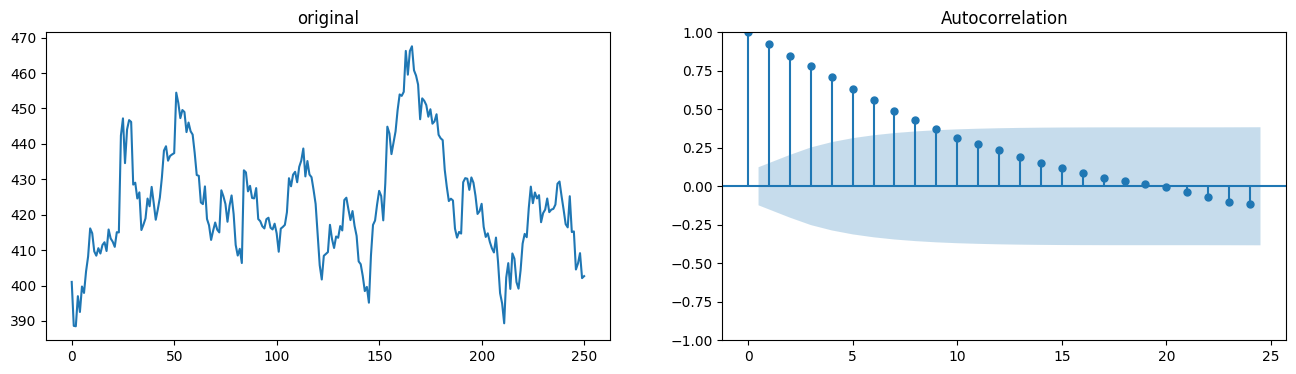

In [22]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df1.Close)
ax1.set_title("original")

plot_acf(df1.Close , ax=ax2); #adding ; at the end so that the plots are not duplicated 

In [39]:
#to directly find the degree of difference d?
from statsmodels.tsa.stattools import adfuller

def adf_test(series, significance=0.05):
    """Returns the minimum differencing order needed for stationarity"""
    d = 0
    p_value = adfuller(series)[1]  # Get p-value from ADF test
    while p_value > significance:
        d += 1
        series = series.diff().dropna()  # Differencing
        p_value = adfuller(series)[1]  # Recalculate p-value
    return d

# Example usage:
d_value = adf_test(df1['Close'])
print(f"Recommended differencing order (d): {d_value}")

Recommended differencing order (d): 0


next we pick the value of p
p is the order of the auto regressive term AR term
we can find the required number of AR terms by inspecting the partial automation (PACK) plot.
the partial auto correlation represents the correlation between the series and its lags

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

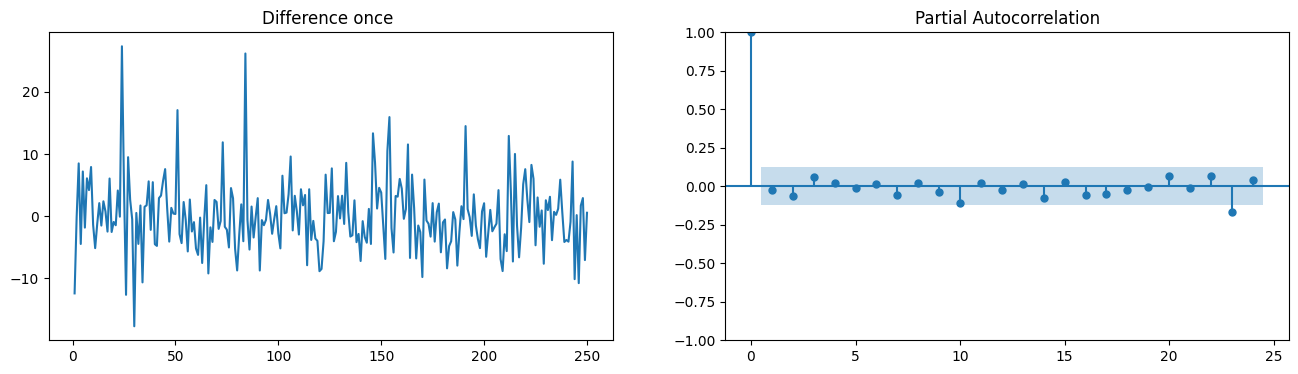

In [32]:
diff = df1.Close.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once ")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2);

C:\Users\spide\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


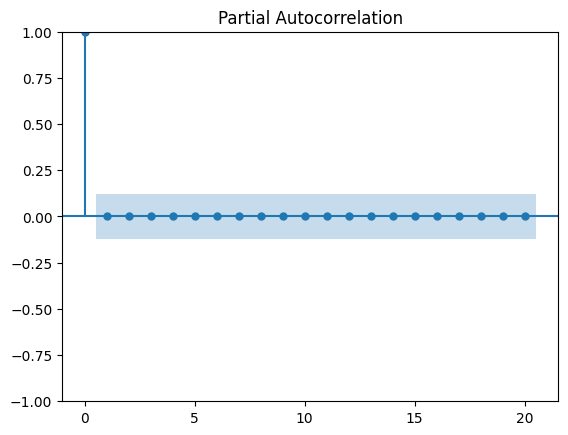

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

d=0

# Plot PACF to determine p
plot_pacf(df1['Close'].diff(d).dropna(), lags=20)
plt.show()

since all the values aare inside the significance range the lag is  contained inside the significant range so the value of p will be taken as 0


now we find the value of q
q is the order of the moving average 

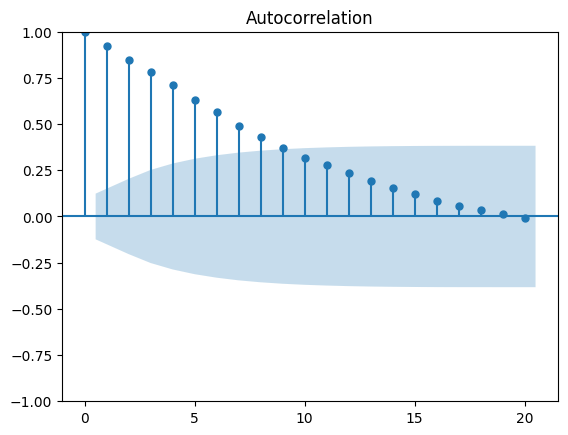

In [38]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df1['Close'], lags=20)  # Since d=0, we don't difference
plt.show()

now this plot shows a constant decline in the data indicating that our time series needs a differentiation but the recomended value is 0 so we go with 0,0 and comparing the q values with 1 and 2

so the  arima model order goes like p,d,q

In [42]:
#fitting the ARIMA model 

from statsmodels.tsa.arima.model import ARIMA

# Try ARIMA(0,0,1)
model_001 = ARIMA(df1['Close'], order=(0, 0, 1))
result_001 = model_001.fit()
print(result_001.summary())

# Try ARIMA(0,0,2)
model_002 = ARIMA(df1['Close'], order=(0, 0, 2))
result_002 = model_002.fit()
print(result_002.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -928.126
Date:                Fri, 07 Mar 2025   AIC                           1862.252
Time:                        12:30:44   BIC                           1872.828
Sample:                             0   HQIC                          1866.508
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        423.1504      1.146    369.383      0.000     420.905     425.396
ma.L1          0.7874      0.044     18.013      0.000       0.702       0.873
sigma2        94.9825      8.611     11.031      0.0

comparing these two the model_002 seems to be better

Model Selection Based on AIC
The AIC (Akaike Information Criterion) helps compare models—lower AIC is better.

ARIMA(0,0,1) → AIC = 1862.252
ARIMA(0,0,2) → AIC = 1752.474 ✅ (Lower AIC, better model)
Analysis of Model(0,0,2) vs. Model(0,0,1)
1. Model Fit:
The ARIMA(0,0,2) model has a significantly lower AIC than ARIMA(0,0,1), suggesting a better fit.
Both MA coefficients (ma.L1, ma.L2) in ARIMA(0,0,2) are significant (p < 0.05).
2. Residual Diagnostics (Ljung-Box & Jarque-Bera Tests)
Ljung-Box (Q) Test:
ARIMA(0,0,1) → Q = 81.23 (bad, high autocorrelation)
ARIMA(0,0,2) → Q = 16.14 (better residuals, less autocorrelation) ✅
Jarque-Bera (JB) Test (Normality of Residuals):
ARIMA(0,0,1) → JB = 8.45 (p = 0.01)
ARIMA(0,0,2) → JB = 17.59 (p = 0.00)
Both models show non-normal residuals, but ARIMA(0,0,2) is still the better choice.
Final Recommendation
✅ Choose ARIMA(0,0,2) as it has:

A much lower AIC (better fit).
Better residual autocorrelation properties.
Significant moving average terms (q=2 is correct).

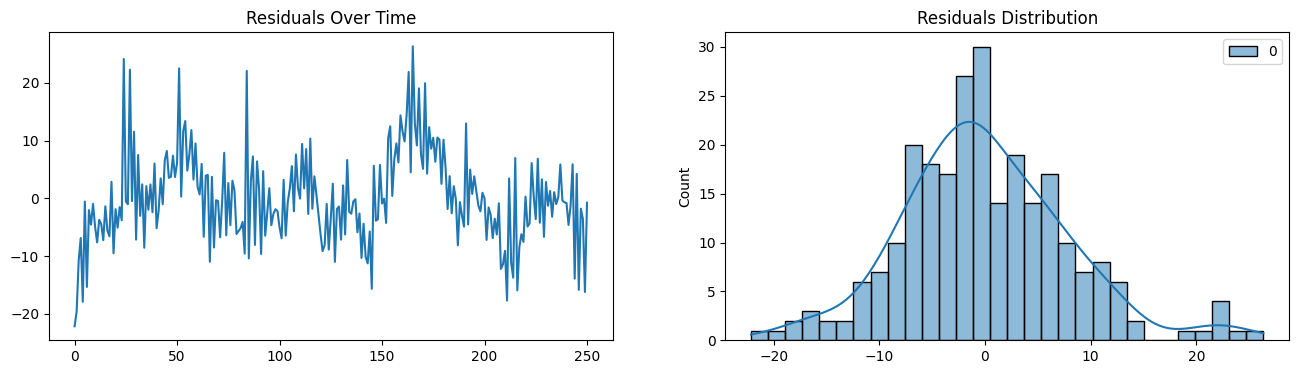

In [45]:
# finding the residuals 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get residuals
residuals = pd.DataFrame(result_002.resid)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Plot residuals over time
ax1.plot(residuals)
ax1.set_title("Residuals Over Time")

# Plot histogram with density curve
sns.histplot(residuals, bins=30, kde=True, ax=ax2)
ax2.set_title("Residuals Distribution")

plt.show()

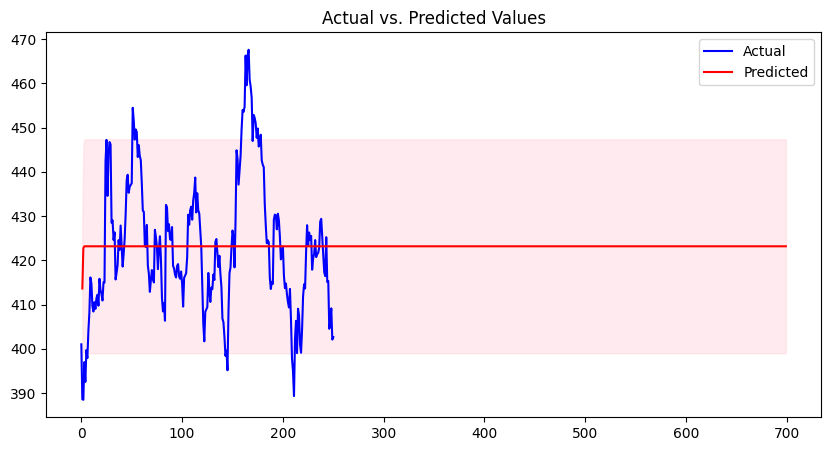

In [48]:
import matplotlib.pyplot as plt

# Define forecast range
start = 1
end = 60

# Get predictions
forecast = result_002.get_forecast(steps=end - start)

# Get confidence intervals
forecast_index = range(start, end)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(df1['Close'], label="Actual", color="blue")  # Actual data
plt.plot(forecast_index, forecast_mean, label="Predicted", color="red")  # Forecasted values
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="pink", alpha=0.3)  # Confidence intervals
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.show()
